##IMPORTS


In [ ]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import random
import cv2

from sklearn.model_selection import train_test_split

import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

## Load Dataset


In [ ]:
root = "ied_detection/"

In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: ied_detection/brown-glass/brown-glass1.jpg  
  inflating: ied_detection/brown-glass/brown-glass10.jpg  
  inflating: ied_detection/brown-glass/brown-glass166.jpg  
  inflating: ied_detection/brown-glass/brown-glass167.jpg  
  inflating: ied_detection/brown-glass/brown-glass168.jpg  
  inflating: ied_detection/brown-glass/brown-glass169.jpg  
  inflating: ied_detection/brown-glass/brown-glass170.jpg  
  inflating: ied_detection/brown-glass/brown-glass171.jpg  
  inflating: ied_detection/brown-glass/brown-glass172.jpg  
  inflating: ied_detection/brown-glass/brown-glass173.jpg  
  inflating: ied_detection/brown-glass/brown-glass174.jpg  
  inflating: ied_detection/brown-glass/brown-glass175.jpg  
  inflating: ied_detection/brown-glass/brown-glass176.jpg  
  inflating: ied_detection/brown-glass/brown-glass177.jpg  
  inflating: ied_detection/brown-glass/brown-glass178.jpg  
  inflating: ied_detection/brown-glass/brown-glass179.jpg  
  inflating: ied_dete

In [ ]:
import os


def load_dataset(root):
    """
    Load dataset from the specified root directory.

    Args:
        root (str): The root directory path.

    Returns:
        dict: A dictionary containing file paths as keys and corresponding labels as values.
    """
    data = {}
    for i in os.listdir(root):
        for j in os.walk(root + i):
            for k in j[2]:
                data[root + i + "/" + k] = i

    return data


data = load_dataset(root)

In [ ]:
data = pd.DataFrame(data.items(), columns=["path", "class_"])
df = data.sample(frac=1)
df

,path,class_
587,ied_detection/shoes/shoes89.jpg,shoes
513,ied_detection/paper/paper27.jpg,paper
699,ied_detection/brown-glass/brown-glass189.jpg,brown-glass
554,ied_detection/shoes/shoes40.jpg,shoes
171,ied_detection/trash/trash657.jpg,trash
...,...,...
266,ied_detection/green-glass/green-glass72.jpg,green-glass
6,ied_detection/cloths/clothes118.jpg,cloths
167,ied_detection/trash/trash669.jpg,trash
146,ied_detection/trash/trash655.jpg,trash


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750 entries, 587 to 521
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    750 non-null    object
 1   class_  750 non-null    object
dtypes: object(2)
memory usage: 17.6+ KB


### Splitting Dataset into train, test and validation sets


In [ ]:
# We first split the data into two sets and then split the validate_df to two sets

train_df, validate_df = train_test_split(df, test_size=0.3, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train = train_df.reset_index(drop=True)
validation = validate_df.reset_index(drop=True)
test = test_df.reset_index(drop=True)

total_train = train.shape[0]
total_validate = validation.shape[0]

In [ ]:
print(train.shape)
print(test.shape)
print(validation.shape)

(525, 2)
(113, 2)
(112, 2)


In [ ]:
class_names = train_df.class_.unique()
print(class_names)

['paper' 'cardboard' 'ied-bomb' 'trash' 'cloths' 'plastic' 'shoes'
 'green-glass' 'brown-glass' 'white-glass']


In [ ]:
class_names = test_df.class_.unique()
print(class_names)

['brown-glass' 'white-glass' 'paper' 'trash' 'cloths' 'green-glass'
 'cardboard' 'ied-bomb' 'shoes' 'plastic']


In [ ]:
class_names = validate_df.class_.unique()
print(class_names)

['brown-glass' 'white-glass' 'paper' 'plastic' 'trash' 'cloths' 'shoes'
 'ied-bomb' 'cardboard' 'green-glass']


In [ ]:
validate_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 692 to 699
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    112 non-null    object
 1   class_  112 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB


In [ ]:
test["class_"].value_counts()

class_
brown-glass    20
trash          20
cloths         14
paper          13
white-glass    11
green-glass    11
shoes           9
cardboard       5
ied-bomb        5
plastic         5
Name: count, dtype: int64

###Some random Images


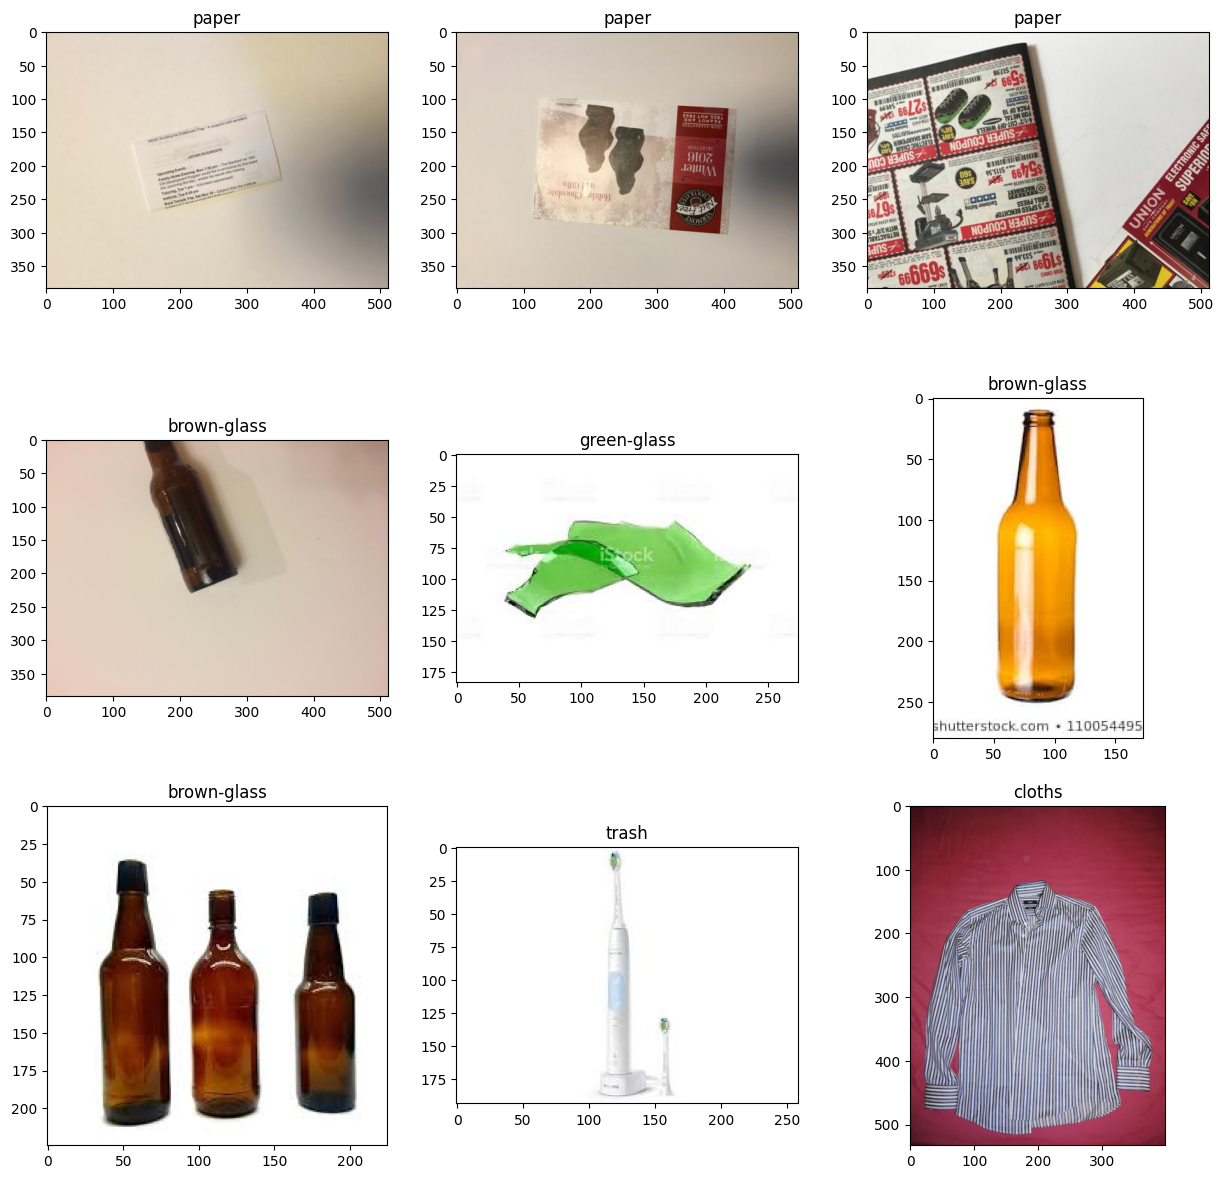

In [ ]:
def display_random_images(df):
    """
    Display random images from a DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing image paths and classes.

    Returns:
        None
    """
    plt.figure(figsize=(15, 15))
    for i in range(9):
        random_row = random.randint(1, 500)
        sample = df.iloc[random_row]
        random_image = tf.keras.utils.load_img(sample["path"])
        plt.subplot(330 + 1 + i)
        plt.title(sample["class_"])
        plt.imshow(random_image)
    plt.show()


display_random_images(train)

### Visualize the Class Distribution


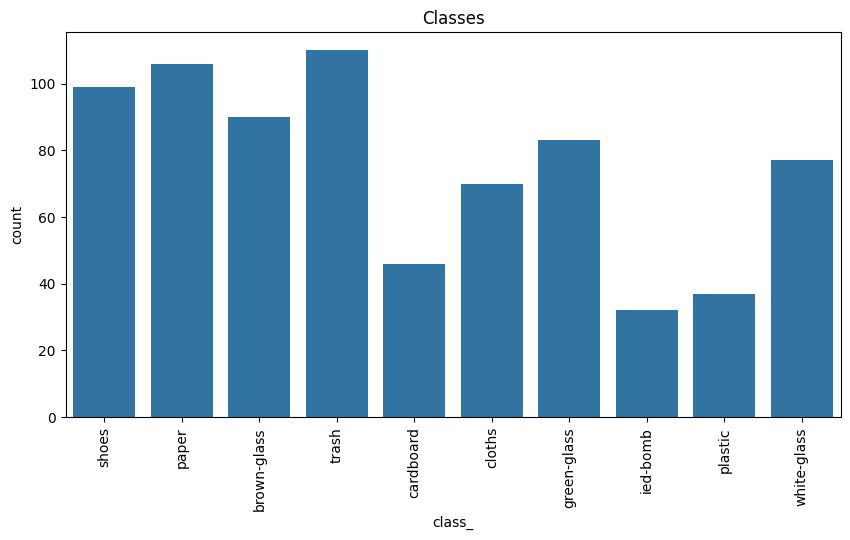

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(x="class_", data=df)
plt.xticks(rotation=90)
plt.title("Classes")
plt.show()

## Image Preprocessing


In [ ]:
batch_size = 16
size = 224
epoch = 50
train_datagen = ImageDataGenerator(rescale=1.0 / 255)

# flow_from_dataframe method to load images from the dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="path",
    y_col="class_",
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input",
)

# Normalize image
# pixel values of the images will be rescaled to the range [0, 1]
valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
valid_generator = train_datagen.flow_from_dataframe(
    dataframe=validation,
    x_col="path",
    y_col="class_",
    target_size=(size, size),
    batch_size=batch_size,
    class_mode="input",
)

Found 520 validated image filenames.
Found 109 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 3 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def se_block_enc(inputs, alpha):
    """
    Applies the Squeeze-and-Excitation (SE) block to the input tensor.

    Args:
        inputs: Input tensor of shape (batch_size, height, width, channels).
        alpha: Number of units in the intermediate dense layer.

    Returns:
        Output tensor after applying the SE block, with the same shape as the input tensor.
    """
    input_channels = inputs.shape[-1]  # extracts number of channels
    x = tf.keras.layers.GlobalAveragePooling2D()(
        inputs
    )  # computes the average value for each channel across the spatial dimensions (height and width)
    x = tf.keras.layers.Dense(units=alpha, activation="relu")(
        x
    )  # performs linear transformation
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)
    x = tf.reshape(
        x, [-1, 1, 1, input_channels]
    )  # reshapes the tensor x to match the spatial dimensions
    x = inputs * x  # channel-wise scaling
    return x

In [ ]:
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPooling2D,
    UpSampling2D,
)


from tensorflow.keras.layers import Input



# Encoding the image
size = 224


input_img = Input(shape=(size, size, 3))  # 3-RGB



# 1st layer


x = Conv2D(48, (3, 3), activation="relu", padding="same")(input_img)


x = se_block_enc(x, 20)


x = MaxPooling2D((2, 2), padding="same")(x)



# 2nd layer


x = Conv2D(96, (3, 3), activation="relu", padding="same")(x)


x = se_block_enc(x, 30)


x = MaxPooling2D((2, 2), padding="same")(x)



# 3rd layer


x = Conv2D(192, (3, 3), activation="relu", padding="same")(x)


x = se_block_enc(x, 50)


x = MaxPooling2D((2, 2), padding="same")(x)


encoded = Conv2D(32, (1, 1), activation="relu", padding="same")(x)



# Bottleneck layer


latentSize = (28, 28, 32)



# Decoding the image


direct_input = Input(shape=latentSize)


x = Conv2D(192, (1, 1), activation="relu", padding="same")(direct_input)


x = UpSampling2D((2, 2))(x)  # increases the spatial dimensions


x = Conv2D(192, (3, 3), activation="relu", padding="same")(x)


x = UpSampling2D((2, 2))(x)


x = Conv2D(96, (3, 3), activation="relu", padding="same")(x)


x = UpSampling2D((2, 2))(x)


x = Conv2D(48, (3, 3), activation="relu", padding="same")(x)


x = Conv2D(192, (3, 3), activation="relu", padding="same")(x)



# Output layer


decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)



# COMPILE


encoder = Model(input_img, encoded)


decoder = Model(direct_input, decoded)


autoencoder = Model(input_img, decoder(encoded))

In [ ]:
autoencoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 48)         1344      ['input_1[0][0]']             
                                                                                                  
 global_average_pooling2d (  (None, 48)                   0         ['conv2d[0][0]']              
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 dense (Dense)               (None, 20)                   980       ['global_average_pooling

#### Compiling auto-encoder


In [ ]:
import module

if not hasattr(module, "train_generator"):
    raise ValueError("The variable 'train_generator' is not defined in the 'module' module.")

ModuleNotFoundError: No module named 'module'

In [ ]:
# Check if the train_generator variable is defined in another module
import sys

for module in sys.modules.values():
    if hasattr(module, "train_generator"):
        # Import the train_generator variable from the module
        from module import train_generator
        break

ModuleNotFoundError: No module named 'module'

In [ ]:
# Check if the variable name is correct
print(globals().keys())  # Print all defined variables in the current environment

# Look for a variable that might contain the train generator
for key in globals():
    if "train" in key.lower():
        train_generator = globals()[key]
        break

In [ ]:
# If the train_generator variable is not defined, assign a value to it
if not "train_generator" in globals():
    # Load the train generator from a file or create it here
    train_generator = ...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### Auto-encoder loss graph


In [ ]:
import matplotlib.pyplot as plt


def plot_loss(history):
    """
    Plots the training and validation loss over epochs.

    Args:
        history (History): The training history object containing loss values.

    Returns:
        None
    """
    epochs = list(range(len(history.history["loss"])))
    fig, ax = plt.subplots(1, 2)

    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    fig.set_size_inches(20, 10)

    ax[1].plot(epochs, train_loss, "g-o", color="r", label="Training Loss")
    ax[1].plot(epochs, val_loss, "go-", label="Validation Loss")
    ax[1].set_title("Training Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training Loss")
    plt.show()


plot_loss(history)

In [ ]:
# Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)
train_images = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col="path",
    y_col="class_",
    batch_size=batch_size,
    target_size=(size, size),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=42,
)
valid_images = valid_datagen.flow_from_dataframe(
    dataframe=validation,
    x_col="path",
    y_col="class_",
    batch_size=batch_size,
    target_size=(size, size),
    color_mode="rgb",
    class_mode="categorical",
    shuffle=True,
    seed=42,
)

In [ ]:
# for freezing encoder i.freeze=False
for i in encoder.layers:
    i.freeze = True

## Preparing the images


## Swin Transformer


The provided sectio retrieves a pre-trained model from TensorFlow Hub and creates a Keras model using that pre-trained model as a layer.


In [ ]:
import tensorflow_hub as hub


def get_from_hub(model_url):
    """
    Loads a pre-trained model from TensorFlow Hub.

    Args:
        model_url (str): The URL of the pre-trained model on TensorFlow Hub.

    Returns:
        tf.keras.Model: The loaded model.

    """
    inputs = tf.keras.Input((224, 224, 3))
    hub_module = hub.KerasLayer(model_url, trainable=False)
    outputs = hub_module(inputs)
    return tf.keras.Model(inputs, outputs)

In [ ]:
def se_block(inputs):
    """
    Squeeze-and-Excitation block implementation.

    Args:
        inputs: Input tensor.

    Returns:
        Output tensor after applying the Squeeze-and-Excitation block.
    """
    input_channels = inputs.shape[-1]
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(
        units=len(train_images.class_indices.keys()), activation="relu"
    )(x)
    x = tf.keras.layers.Dense(units=input_channels, activation="sigmoid")(x)
    x = tf.reshape(x, [-1, 1, 1, input_channels])
    x = inputs * x
    return x

In [ ]:
# get the model from the hub
swin = get_from_hub(
    "https://tfhub.dev/sayakpaul/swin_large_patch4_window7_224_in22k_fe/1"
)

In [ ]:
from tensorflow.keras import regularizers

x = swin.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(
    32,
    kernel_regularizer=regularizers.l2(l=0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation="relu",
)(x)
x = Dense(256, activation="relu")(x)
x_swin = Dense(128, activation="relu")(x)

In [ ]:
def get_model(base_model):
    """
    Creates a custom model by adding additional layers on top of a base model.

    Args:
        base_model: The base model on top of which the custom model is built.

    Returns:
        A custom model with additional layers.

    """
    x = tf.keras.layers.GlobalAveragePooling2D()(se_block(base_model.output))
    x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
    x = Dense(
        512,
        kernel_regularizer=regularizers.l2(l=0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006),
        activation="relu",
    )(x)
    x = Dense(256, activation="relu")(x)
    return Dense(128, activation="relu")(x)

In [ ]:
x_encoder = get_model(encoder)

### Model


In [ ]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import plot_model

concatenated = concatenate([x_encoder, x_swin])
bigmodel_prediction = Dense(len(train_images.class_indices), activation="softmax")(
    concatenated
)
model = Model([encoder.input, swin.input], bigmodel_prediction)

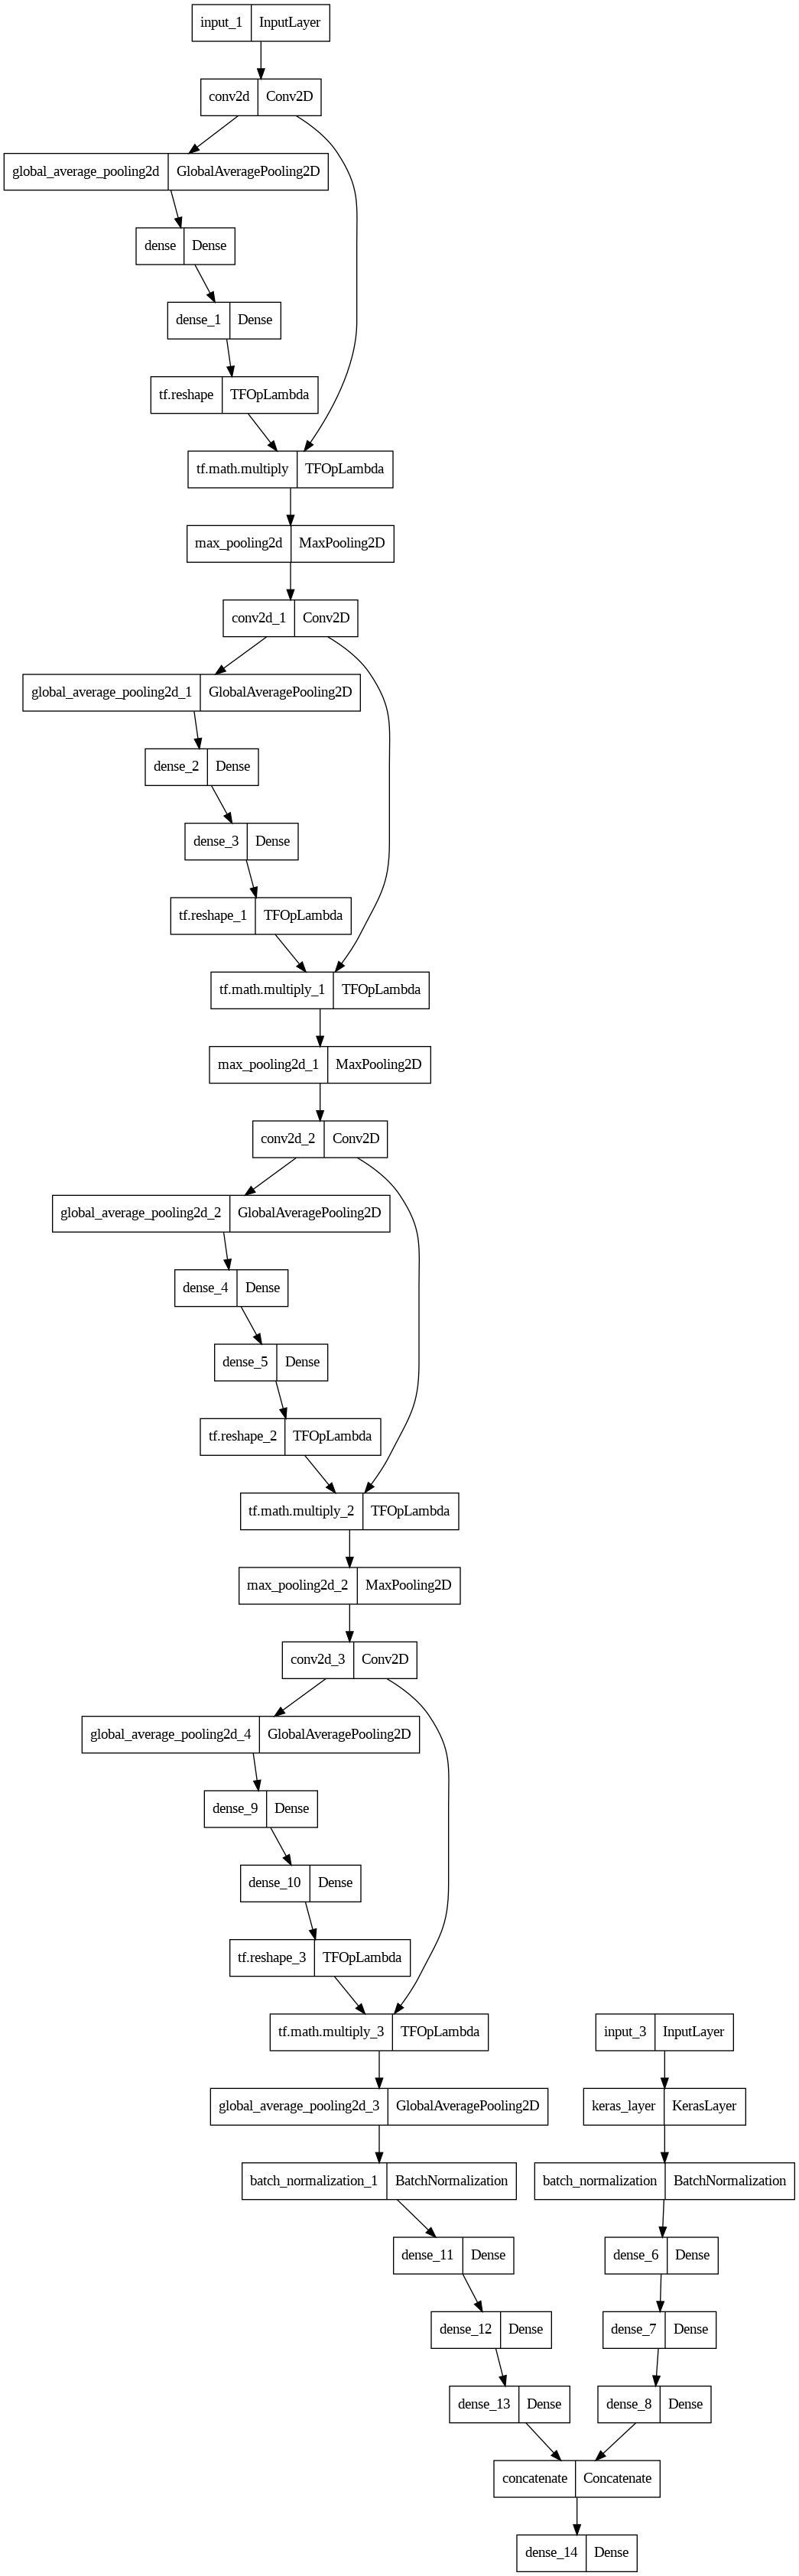

In [ ]:
plot_model(model)

In [ ]:
trainable_params = sum([v.numpy().size for v in model.trainable_variables])
non_trainable_params = sum([v.numpy().size for v in model.non_trainable_variables])

print(
    f"trainable parameters: {trainable_params} non-trainable parameters: {non_trainable_params}"
)

trainable parameters: 520520 non-trainable parameters: 194998612


Generators


In [ ]:
def generator_two_img(gen):
    while True:
        X1i = gen.next()
        yield [X1i[0], X1i[0]], X1i[1]

## Training


In [ ]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.experimental.Adamax(),
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    generator_two_img(train_images),
    validation_data=generator_two_img(valid_images),
    validation_steps=valid_images.n // batch_size,
    validation_batch_size=batch_size,
    steps_per_epoch=train_generator.n // batch_size,
    batch_size=batch_size,
    epochs=epoch,
)

Epoch 1/50
32/32 [==============================] - 54s 765ms/step - loss: 3.5588 - accuracy: 0.4629 - val_loss: 3.4571 - val_accuracy: 0.5104
Epoch 2/50
32/32 [==============================] - 22s 711ms/step - loss: 2.1823 - accuracy: 0.8171 - val_loss: 2.7765 - val_accuracy: 0.7553
Epoch 3/50
32/32 [==============================] - 23s 707ms/step - loss: 1.5577 - accuracy: 0.9105 - val_loss: 2.2134 - val_accuracy: 0.8723
Epoch 4/50
32/32 [==============================] - 20s 641ms/step - loss: 1.2875 - accuracy: 0.9225 - val_loss: 1.7974 - val_accuracy: 0.9043
Epoch 5/50
32/32 [==============================] - 23s 719ms/step - loss: 1.1137 - accuracy: 0.9622 - val_loss: 1.4714 - val_accuracy: 0.9787
Epoch 6/50
32/32 [==============================] - 21s 650ms/step - loss: 0.9867 - accuracy: 0.9662 - val_loss: 1.2710 - val_accuracy: 0.9574
Epoch 7/50
32/32 [==============================] - 21s 660ms/step - loss: 0.8835 - accuracy: 0.9781 - val_loss: 1.0256 - val_accuracy: 0.9468

## Performance Eval


In [ ]:
history_dict = history.history

<ipython-input-44-8cd8d0994033>:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go-" (-> color='g'). The keyword argument will take precedence.
  ax[0].plot(epochs, train_acc, "go-", color="r", label="Training Accuracy")
<ipython-input-44-8cd8d0994033>:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g-o" (-> color='g'). The keyword argument will take precedence.
  ax[1].plot(epochs, train_loss, "g-o", color="r", label="Training Loss")


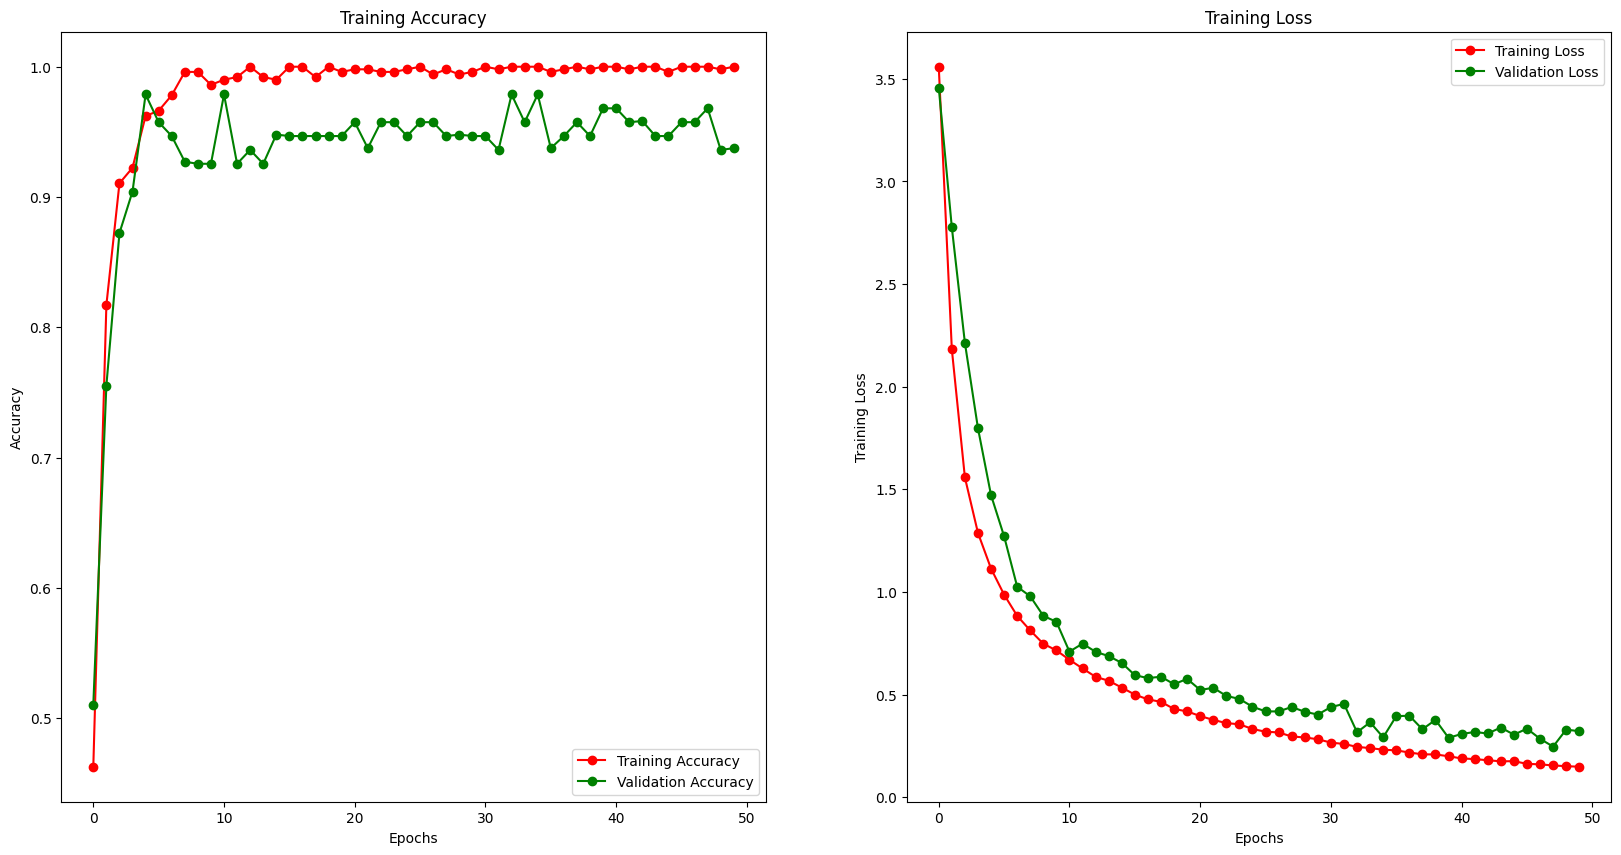

In [ ]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    """
    Plots the training accuracy and loss over epochs.

    Args:
        history (History): The training history object obtained from model.fit().

    Returns:
        None
    """
    epochs = list(range(len(history.history["accuracy"])))
    fig, ax = plt.subplots(1, 2)
    train_acc = history.history["accuracy"]
    train_loss = history.history["loss"]
    val_acc = history.history["val_accuracy"]
    val_loss = history.history["val_loss"]

    fig.set_size_inches(20, 10)

    ax[0].plot(epochs, train_acc, "go-", color="r", label="Training Accuracy")
    ax[0].plot(epochs, val_acc, "go-", label="Validation Accuracy")
    ax[0].set_title("Training Accuracy")
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs, train_loss, "g-o", color="r", label="Training Loss")
    ax[1].plot(epochs, val_loss, "go-", label="Validation Loss")
    ax[1].set_title("Training Loss")
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training Loss")
    plt.show()


plot_training_history(history)

## Testing


In [ ]:
class_ = train_images.class_indices.keys()

In [ ]:
test_generator = ImageDataGenerator(
    rescale=1.0 / 255,
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test,
    x_col="path",
    y_col="class_",
    target_size=(size, size),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    subset="training",
)

Found 113 validated image filenames belonging to 10 classes.


In [ ]:
def prediction_generator(test_images):
    """
    Generates predictions for test images.

    Args:
        test_images (list): A list of test images.

    Yields:
        tuple: A tuple containing the input image and its corresponding prediction.

    """
    k = 0
    for x in test_images:
        k += len(x[1])
        yield [x[0], x[0]], x[1]
        if k >= test_images.n:
            break

### Accuracy


In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
proba = model.predict(prediction_generator(test_images))
predicted = np.argmax(proba, axis=1)
true = test_images.labels
accuracy_score(predicted, true)

8/8 [==============================] - 7s 495ms/step


0.9026548672566371

#### Confusion Matrix


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

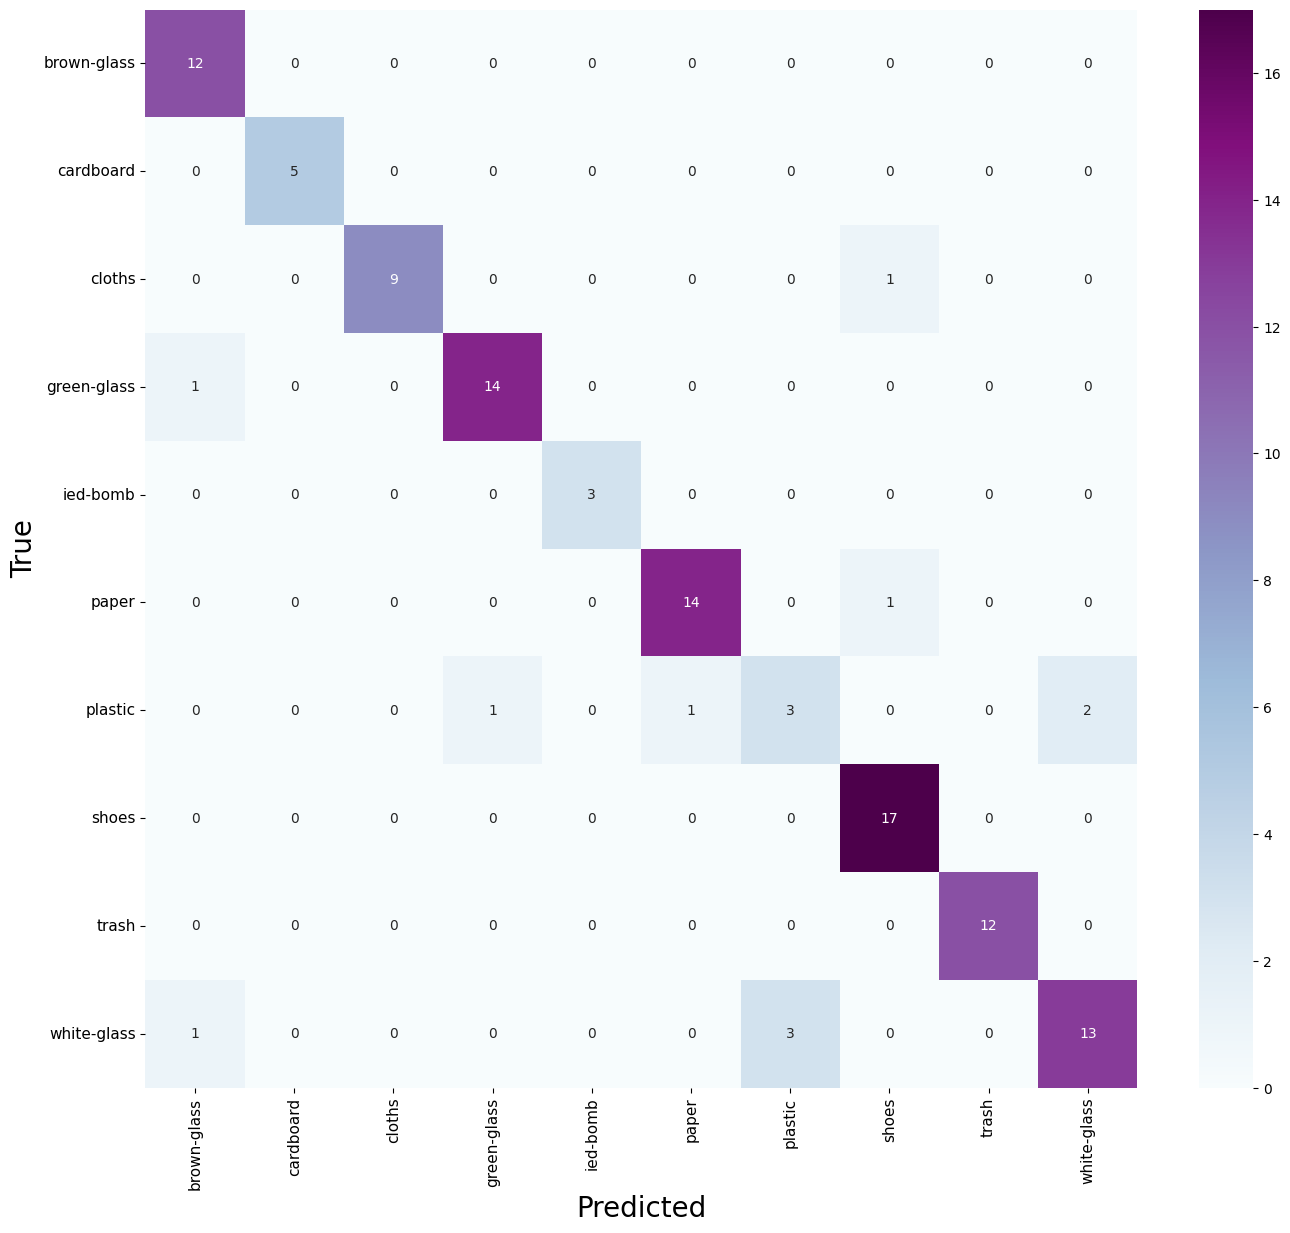

In [ ]:
def plot_confusion_matrix(true, predicted, test_images):
    """
    Plots a confusion matrix based on the true and predicted labels.

    Args:
        true (array-like): The true labels.
        predicted (array-like): The predicted labels.
        test_images (object): An object containing the class indices.

    Returns:
        None
    """
    class_ = test_images.class_indices.keys()
    cm = confusion_matrix(true, predicted)
    fig = plt.figure(figsize=(16, 14))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap="BuPu")
    ax.set_xlabel("Predicted", fontsize=20)
    ax.xaxis.set_label_position("bottom")
    plt.xticks(rotation=90)
    ax.xaxis.set_ticklabels(class_, fontsize=11)
    ax.xaxis.tick_bottom()

    ax.set_ylabel("True", fontsize=20)
    ax.yaxis.set_ticklabels(class_, fontsize=11)
    plt.yticks(rotation=0)

    plt.title("", fontsize=60)

    plt.savefig("ConMat.png")
    plt.show()


plot_confusion_matrix(true, predicted, test_images)